# Hand-on Exercise

As an exercise, we are going to try to determine the amount of money in the following image:

<img src='../sample-images/quarters_dimes_pennies.png'>

I took this picture with my phone, and it contains only quarters, dimes and pennies (no nickels). I've broken down the analysis into a step-by-step procedure. Most of the steps can be completed with the functions that I introduced in the lecture. However, in step 6, you will have to look up the documentation for the relevent functions to learn how to use them.  

**Step 1: Reading & displaying the image.** Use matplotlib to read the file "`sample-images/quarters_dimes_pennies.png`". Convert it to grayscale and display both the original and grayscle images.

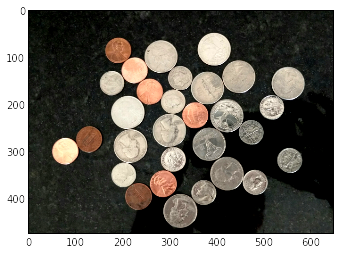

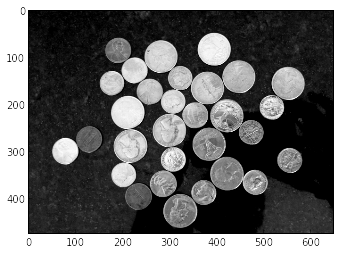

In [7]:
import matplotlib.pyplot as plt
from skimage import color, feature
%matplotlib inline


im = plt.imread('../sample-images/quarters_dimes_pennies.png')
gray_im = color.rgb2gray(im)

plt.imshow(im)
plt.figure()
plt.imshow(gray_im, cmap='gray')

The coins are much brighter than the background, so it should be straightforward to create a mask for the coins. 

**Step 2: Thresholding.** Create a binary mask by thresholding the grayscale image. You can use a histogram and some guesswork to determine the threshold or use one of the threshold functions in `skimage.filters`.

Selected a threshold of 0.29


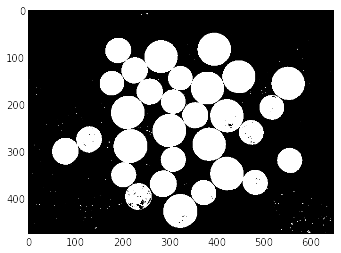

In [8]:
from skimage.filters import threshold_li

coin_thresh = threshold_li(gray_im)
print 'Selected a threshold of %.2f' % coin_thresh
coin_mask = gray_im > coin_thresh
plt.imshow(coin_mask, cmap='gray');

**Step 3: Cleaning up the mask.** Your mask will inevitably have some noise. Use morphology operators to clean up the mask. It doesn't have to be 100% perfect, but you should be able to get rid of the specks.

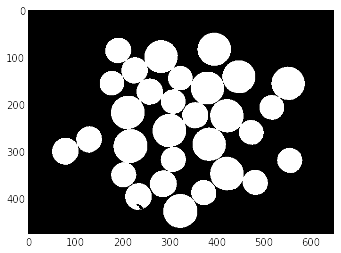

In [9]:
from skimage import morphology
from skimage.morphology import disk

coin_mask_clean = morphology.remove_small_objects(coin_mask)
coin_mask_clean = ~morphology.remove_small_objects(~coin_mask_clean)

plt.imshow(coin_mask_clean, cmap='gray');

**Step 4: Masking.** It will be convenient to set the background to black. Use the coin mask that you created to set the backgrounds of both the original color image, and the grayscale image to zero. 

You should be able to see the coins in color, but the counter (and the reflections in the counter) should be black. While you're at it, set the background of the grayscale image to zero as well. From now on, we don't have to worry about the background affecting our results because we've masked it out.

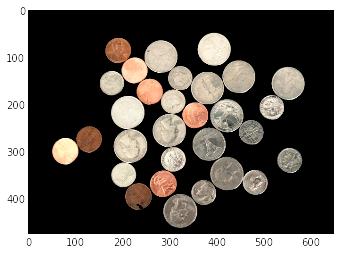

In [10]:
bg_mask = ~coin_mask_clean

im[bg_mask] = 0
gray_im[bg_mask] = 0
plt.imshow(im);

Now that we've segmented the foreground from the background, we want to distinguish the coins from each other. 

**Step 5: Watershed Segmentation** Use the watershed-based segmentation that was introduced in the cell counting demo to create a label image for the coins. Print the number of coins in the image. 

There are 30 coins in the image.


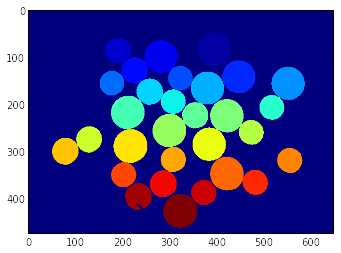

In [11]:
from scipy import ndimage as ndi
from skimage import measure
import numpy as np
from BKlib import print_image_properties

def watershed_segmentation(mask):
    distance_im = ndi.distance_transform_edt(mask)
    peaks = feature.peak_local_max(distance_im, indices=True)
    peaks_im = np.zeros(distance_im.shape, dtype=bool)
    for row, col in peaks:
        peaks_im[row, col] = 1
    markers_im = measure.label(peaks_im)
    labelled_im = morphology.watershed(-distance_im, markers_im, mask=coin_mask_clean)
    return labelled_im


labelled_coin_im = watershed_segmentation(coin_mask_clean)

print 'There are %i coins in the image.' % (len(np.unique(labelled_coin_im)) - 1)
plt.imshow(labelled_coin_im);


**Step 6: Quantifying & displaying the object sizes.** Look up the documentation for scikit-image function `regionprops` online. Use this function with the labelled coins image to compute the area of each coin and the location of each coin's center (the center is called the "centroid"). Display the image and use matplotlib's `text` function to write the area of each coin at its center.

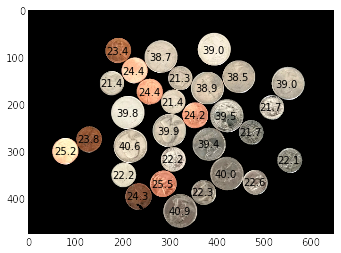

In [12]:
regions = measure.regionprops(labelled_coin_im)

plt.imshow(im)

for region in regions:
    y, x = region.centroid
    area = region.area
    area_str = '%.1f' % (area/100)
    plt.text(x, y, area_str, color='k', ha='center', va='center')  # ha, va = horizontal alignment,vertical aligment

**Step 7: Separate coins by size & count.** It is possible to sort the coins on the basis of size. By trial and error, select size thresholds that can use a region's area to determine the coin's denomination. Count the number of each denomination, and print the total value of the coins in the image.

12 quarters, 10 dimes, 8 pennies
Total value of coins is $4.08


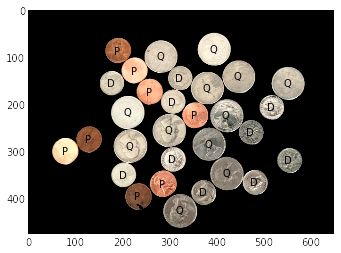

In [13]:

# I got these thresholds by examining area-labeled plot (and by trial-and-error) 
max_dime_area = 2300
min_quarter_area = 3800

num_dimes = 0
num_quarters = 0
num_pennies = 0

plt.imshow(im)

for region in regions:
    y, x = region.centroid
    area = region.area
    if area <= max_dime_area:  # small regions are dimes
        coin_name = 'D'
        num_dimes += 1
    elif area >= min_quarter_area:  # big regions are quarters
        coin_name = 'Q'
        num_quarters += 1
    else:  # everything else is pennies
        coin_name = 'P'
        num_pennies += 1
    plt.text(x, y, coin_name, ha='center', va='center')  # ha, va = horizontal alignment,vertical aligment
    
value = (25.*num_quarters + 10.*num_dimes + num_pennies)/100 
print '%i quarters, %i dimes, %i pennies' %(num_quarters, num_dimes, num_pennies)
print 'Total value of coins is $%.2f' % value